# Notebook objective:
In this notebook, I investigate how much of a model's performance comes from the algorithm itself and how much comes from feature representation. To that end, we will compare three different approaches for training the model:
 - **Baseline**: Without any feature processing.
 - **Simple Feature Engineering**: Applying scaling or basic transformations.
 - **Advanced Feature Engineering**: Computing intelligent features.

To ensure a fair comparison, we will use the same model structure throughout; thus, any performance changes will be solely due to the input features.

# Problem Framing

Our objective is to predict house prices using 80 different features. This is a regression problem, and we will use a Ridge Regression model.

As in the competition, we will evaluate the model performance using the Root Mean Squared Error (RMSE):
$$
RMSE = \sqrt{\frac{1}{n} \sum_{i = 1}^{n} (y_i - \tilde{y}_{i})^2}
$$

We will use this same loss function to train and evaluate the model.
Since RMSE is very sensitive to outliers, we will pay special attention to handling extreme values to minimize their negative impact on the competition score.

# Baseline: Without any feature processing.

Shape of the data:  (1460, 81)


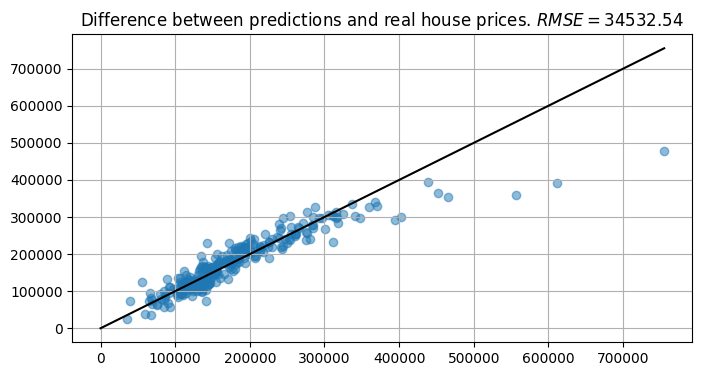

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

# set all seeds to 42
np.random.seed(42)
random.seed(42)

# load data
data = pd.read_csv('train.csv')

print("Shape of the data: ",data.shape)

# split features and target
X = data.drop('SalePrice',axis = 1)
y = data['SalePrice']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

# specify between continuous and discrete columns
cont_cols = X_train.select_dtypes(include=['number']).columns.tolist() # continuous (or at least numerical)
disc_cols = X_train.select_dtypes(include=['object', 'category','str']).columns.tolist() # discrete 

# define the transformation of the discrete data
discrete_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # for NaN values
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
# define the transformation of the continuous data
continuous_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', continuous_transformer, cont_cols),
        ('cat', discrete_transformer, disc_cols)
    ])

# create the model
model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

# train the model
model.fit(X_train,y_train)

# make predictions
y_preds = model.predict(X_test)

# compare real data with predictions
rmse = root_mean_squared_error(y_true=y_test,y_pred = y_preds)

# plot the differences
plt.figure(figsize = (8,4))
plt.scatter(y_test,y_preds,alpha=0.5)
plt.plot([0,np.max([*y_preds,*y_test])], [0,np.max([*y_preds,*y_test])], 'k-')
plt.title(f"Difference between predictions and real house prices. $RMSE = {rmse:.2f}$")
plt.grid()
plt.show()

Let's evaluate the model on the test data to submit to the Kaggle competition.

In [ ]:
data_test = pd.read_csv("test.csv")
test_id = data_test['Id']

# make predictions
predictions = model.predict(data_test)

df_final = pd.DataFrame({
    'Id': test_id,
    'SalePrice': predictions
})
df_final.to_csv('baseline_model.csv', index=False)

The score obtained from this model is **0.32534**, which is lower than 91% of the teams. This is a poor result, we can improve it.

# Simple Feature Engineering: Applying scaling or basic transformations.


## Data Study

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("train.csv")

First, lets try to find some outliers in the data

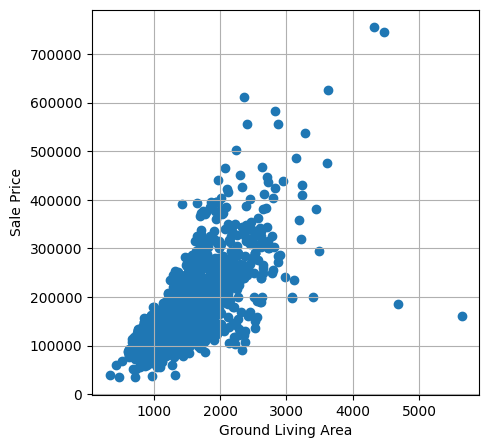

In [57]:
plt.figure(figsize=(5,5))
plt.scatter(data['GrLivArea'],data['SalePrice'])
plt.grid()
plt.xlabel("Ground Living Area")
plt.ylabel("Sale Price")
plt.show()

We can observe two data points with high living area but relatively low prices. We will remove these outliers from the dataset to minimize the impact of extreme values on the model.

Now, let's examine the continuous data by plotting all numeric columns in histograms.

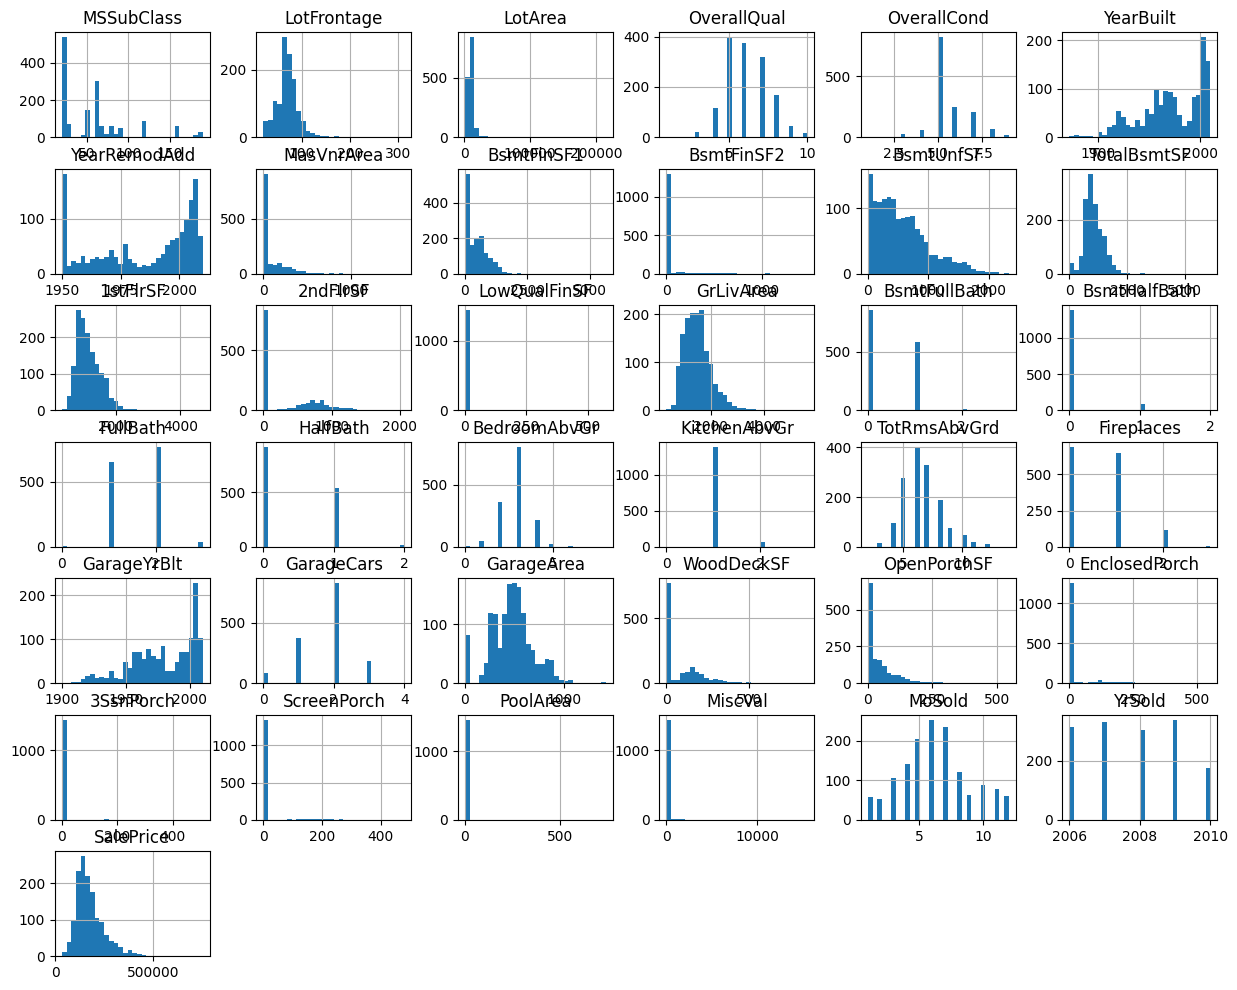

In [58]:
data.drop("Id",axis = 1).hist(bins = 30,figsize=(15,12))
plt.show()

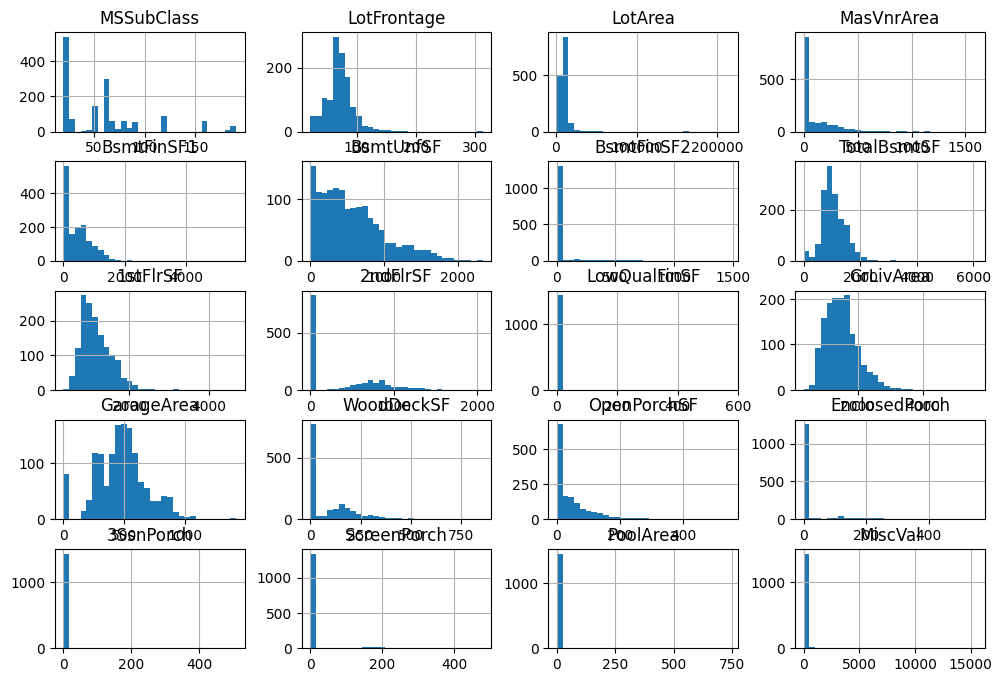

In [62]:
continuous_columns = ['MSSubClass','LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtUnfSF','BsmtFinSF2','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']
data[continuous_columns].hist(bins = 30,figsize=(12,8))
plt.show()

As we can see, these distributions are highly skewed. We need to will apply the Yeo-Johnson transformation to approximate the data to a normal distribution as much as possible.


Now, we will examine the count variables, such as the number of bathrooms. We will apply a RobustScaler to these features to ensure that the scaling is not distorted by potential outliers.

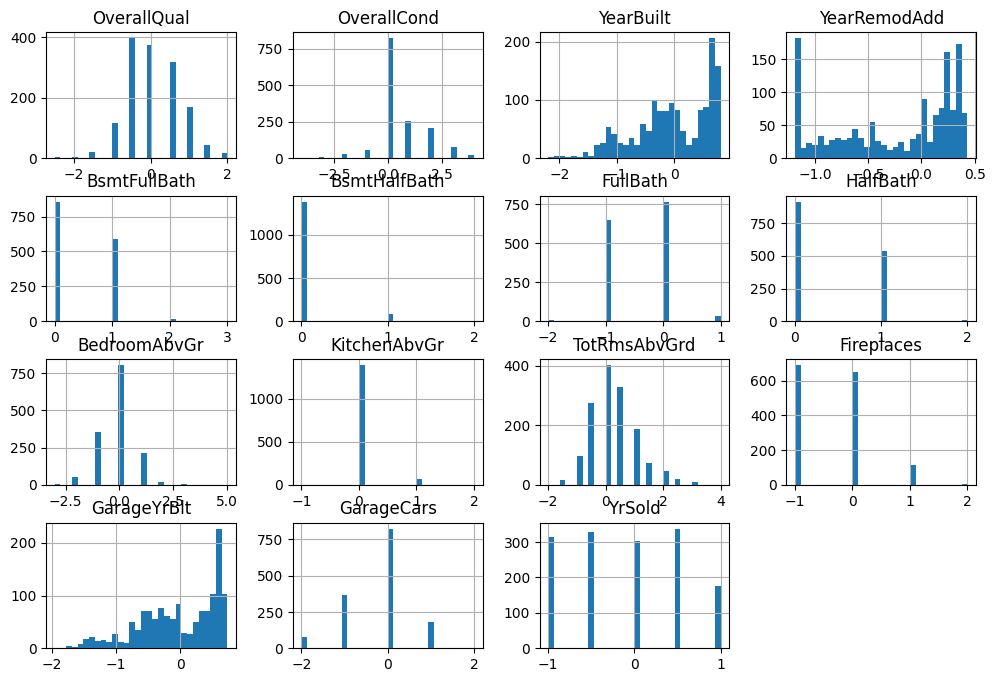

In [63]:
from sklearn.preprocessing import RobustScaler

rs = RobustScaler()
discrete_numerical_columns = ['OverallQual','OverallCond','YearBuilt','YearRemodAdd','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','YrSold']

data_transformed_df = pd.DataFrame(rs.fit_transform(data[discrete_numerical_columns]), columns=discrete_numerical_columns)

data_transformed_df.hist(bins=30, figsize=(12, 8))
plt.show()

Finally, we will perform cyclical encoding for the 'month sold' by mapping it to a 2D vector $(x, y)$ using sine and cosine transformations. This ensures that the circular nature of the months is preserved, making December and January numerically close.

Now lets study the non numerical columns

In [57]:
total_cols = set(data.columns)
numerical_cols = set(data.select_dtypes(include = ['number']).columns)
non_numerical_columns = list(total_cols - numerical_cols)

We have two types of categorical variables: ordinal and nominal. The key difference lies in the order: ordinal variables have a natural, meaningful ranking (such as 'Low', 'Medium', 'High'), whereas nominal variables represent distinct categories without any inherent order (such as 'Color' or 'City')

Inside the ordinal columns we have a group that share a common quality scale (*Ex, Gd, TA, Fa, Po*) This columns are:
* `ExterQual`, `ExterCond`, `BsmtQual`, `BsmtCond`, `HeatingQC`, `KitchenQual`, `FireplaceQu`, `GarageQual`, `GarageCond`, `PoolQC`.

The rest of nominal features can have the values:

| Feature | Values (Ordered Hierarchy) |
| :--- | :--- |
| **PavedDrive** | `N` , `P` , `Y` |
| **BsmtExposure** | `No`, `Mn` , `Av`, `Gd` |
| **LandSlope** | `Gtl`, `Mod` , `Sev` |
| **BsmtFinType 1/2**| `Unf`, `LwQ`, `Rec`, `BLQ`, `ALQ`, `GLQ` |
| **Utilities** | `NoSeWa`, `AllPub` |
| **LotShape** | `IR3`, `IR2`, `IR1`, `Reg` |
| **GarageFinish** | `Unf`, `RFn`, `Fin` |
| **Fence** | `MnWw`, `GdWo`, `MnPrv`, `GdPrv` |
| **Electrical** | `Mix`, `FuseP`, `FuseF`, `FuseA`, `SBrkr` |
| **Functional** | `Sev`, `Maj2`, `Maj1`, `Mod`, `Min2`, `Min1`, `Typ` |


The remaining non-numerical columns are considered nominal. Since they do not have an intrinsic order, they will be treated using encoding techniques such as *One-Hot Encoding*.

## Model with Simple Feature Engineering 

In [65]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,PowerTransformer,RobustScaler,FunctionTransformer,StandardScaler,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from typing import List

# set all seeds to 42
np.random.seed(42)
random.seed(42)

data = pd.read_csv('train.csv').drop(columns=['Id'])

# remove outliers
data = data[(data['GrLivArea'] < 4000) | (data['SalePrice'] > 300000)]

print("Shape of the data: ",data.shape)

# split
X = data.drop('SalePrice',axis = 1)
y = data['SalePrice']

#  apply log to the y data
y = np.log(y)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

Shape of the data:  (1458, 80)


In [66]:
# arrays with the different columns we have 
columns_with_continuous_values = ['MSSubClass','LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtUnfSF','BsmtFinSF2',
                                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea','WoodDeckSF',
                                 'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']

columns_with_numerical_counts = ['OverallQual','OverallCond','YearBuilt','YearRemodAdd','BsmtFullBath','BsmtHalfBath','FullBath',
                                 'HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','YrSold']

mo_sold_column = ['MoSold']

columns_with_discrete_quality = ['GarageCond', 'GarageQual', 'ExterQual', 'ExterCond', 'KitchenQual', 
                                    'HeatingQC', 'FireplaceQu', 'BsmtQual', 'BsmtCond','PoolQC'
]

categorical_columns = ['RoofMatl', 'Neighborhood', 'Alley', 'BldgType', 'LotConfig', 'GarageType', 'SaleType', 'Street', 
                       'MSZoning', 'Heating', 'Exterior1st', 'LandContour', 'MasVnrType', 'Exterior2nd', 'SaleCondition', 
                       'HouseStyle', 'CentralAir', 'RoofStyle', 'Foundation', 'Condition1', 'MiscFeature', 'Condition2']
 
 
# create the transformation for the continuous data
continuous_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # for NaN values, put the most frequent
    ('transformer', PowerTransformer(method='yeo-johnson')), # transform the data to make it more gaussian
    ('scaler', RobustScaler()) # scale the data
])

# create the transformation for the numerical counts
numerical_count_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='constant',fill_value = 0)), # fill the NaN values with zero
    ('scaler',RobustScaler()) # scale the data
])

# create the transformation for the month sold column
def transform_cycle(X, period = 12):
    sin_month = np.sin(2*np.pi * X / period)
    cos_month = np.cos(2*np.pi * X / period)
    return np.column_stack([sin_month,cos_month])
mo_sold_transformer = FunctionTransformer(transform_cycle)

# create the transformation for the discrete condition data
def to_upper_case(X):
    return pd.DataFrame(X).map(lambda x: x.upper() if isinstance(x,str) else x)  

def create_pipeline_discrete(categories: List, n_columns: int) -> Pipeline:
    return Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
        ('to_upper', FunctionTransformer(to_upper_case)),
        ('ordinal_map', OrdinalEncoder(categories=[categories] * n_columns)), 
        ('scaler', StandardScaler())
    ])

discrete_related_categories = {
    "quality": ['MISSING', 'PO', 'FA', 'TA', 'GD', 'EX'],
    "GarageFinish": ['MISSING', 'UNF', 'RFN', 'FIN'],
    "PavedDrive": ['MISSING', 'N', 'P', 'Y'],
    "Electrical": ['MISSING', 'MIX', 'FUSEP', 'FUSEF', 'FUSEA', 'SBRKR'],
    "BsmtFinType": ['MISSING', 'UNF', 'LWQ', 'REC', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtExposure": ['MISSING', 'NO', 'MN', 'AV', 'GD'],
    "LotShape": ['MISSING', 'IR3', 'IR2', 'IR1', 'REG'],
    "LandSlope": ['MISSING', 'SEV', 'MOD', 'GTL'],
    "Utilities": ['MISSING', 'NOSEWA', 'ALLPUB'],
    "Functional": ['MISSING', 'SEV', 'MAJ2', 'MAJ1', 'MOD', 'MIN2', 'MIN1', 'TYP'],
    "Fence": ['MISSING', 'MNWW', 'GDWO', 'MNPRV', 'GDPRV']
}

# create the transformation for the category data
category_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # fill NaN with 'missing'
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ('scaler',StandardScaler(with_mean=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cont', continuous_transformer, columns_with_continuous_values),
        ('count', numerical_count_transformer, columns_with_numerical_counts),
        ('mo_sold', FunctionTransformer(transform_cycle), mo_sold_column),
        ('qual', create_pipeline_discrete(discrete_related_categories['quality'], len(columns_with_discrete_quality)), columns_with_discrete_quality),
        
        ('gar_fin', create_pipeline_discrete(discrete_related_categories['GarageFinish'], 1), ['GarageFinish']),
        ('paved', create_pipeline_discrete(discrete_related_categories['PavedDrive'], 1), ['PavedDrive']),
        ('elec', create_pipeline_discrete(discrete_related_categories['Electrical'], 1), ['Electrical']),
        ('bsmt_fin', create_pipeline_discrete(discrete_related_categories['BsmtFinType'], 2), ['BsmtFinType1', 'BsmtFinType2']),
        
        ('bsmt_exp', create_pipeline_discrete(discrete_related_categories['BsmtExposure'], 1), ['BsmtExposure']),
        ('shape', create_pipeline_discrete(discrete_related_categories['LotShape'], 1), ['LotShape']),
        ('slope', create_pipeline_discrete(discrete_related_categories['LandSlope'], 1), ['LandSlope']),
        ('util', create_pipeline_discrete(discrete_related_categories['Utilities'], 1), ['Utilities']),
        ('func', create_pipeline_discrete(discrete_related_categories['Functional'], 1), ['Functional']),
        ('fence', create_pipeline_discrete(discrete_related_categories['Fence'], 1), ['Fence']),
        
        ('cat', category_transformer, categorical_columns)
    ],
    remainder='drop'
)

# create the model
model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

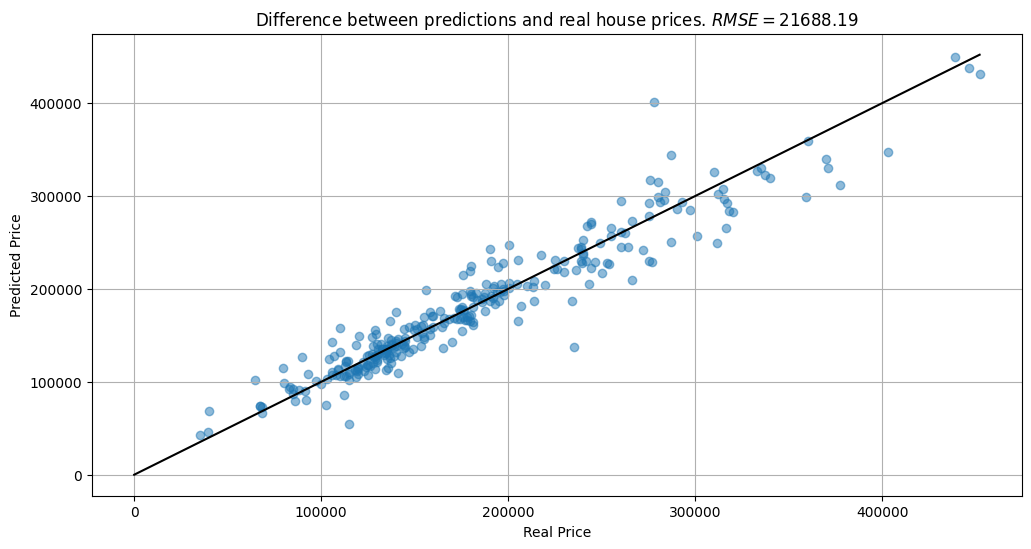

In [67]:
# train the model
model.fit(X_train,y_train)

# make predictions
y_preds = model.predict(X_test)

y_preds = [np.exp(v) for v in y_preds]
y_test = [np.exp(v) for v in y_test]

# compare real data with predictions
rmse = root_mean_squared_error(y_true=y_test,y_pred = y_preds)

# plot the differences
plt.figure(figsize = (12,6))
plt.scatter(y_test,y_preds,alpha=0.5)
plt.plot([0,np.max([*y_preds,*y_test])], [0,np.max([*y_preds,*y_test])], 'k-')
plt.title(f"Difference between predictions and real house prices. $RMSE = {rmse:.2f}$")
plt.xlabel("Real Price")
plt.ylabel("Predicted Price")
plt.grid()
plt.show()

Again evaluating the model in kaggle.

In [69]:
data_test = pd.read_csv("test.csv")
test_id = data_test['Id']

# make predictions
predictions = np.exp(model.predict(data_test))


df_final = pd.DataFrame({
    'Id': test_id,
    'SalePrice': predictions
})
df_final.to_csv('model_simple_featuring.csv', index=False)

The score obtained now is **0.1366**, which is lower than 49% of the teams. We have made some improvements, but we can keep pushing.

#  Advanced Feature Engineering: Computing intelligent features


First, we observe that several continuous variables have a high concentration of zero values (sparsity). Therefore, it would be beneficial to create a binary indicator for each of these features to determine whether the value is zero or not.

We will also introduce non-linear relationships into the model by calculating the powers of specific columns, which can help capture more complex patterns in the data.

Regarding temporal data, we will shift our focus from absolute years (Built/Sold) to relative age. Since the price is more likely influenced by how old the property is rather than the specific year it was constructed, we will compute the house age and the time since the last remodel.

Furthermore, we will engineer several new ratios to capture deeper insights:

* **% Living Area on First Floor**: 
    $$\text{LAIFF} = \frac{\text{1stFlrSF}}{\text{GrLivArea}}$$
* **Ground Living Area per Room**:
    $$\text{GLAPR} = \frac{\text{GrLivArea}}{\text{TotRmsAbvGrd}}$$
* **% Garage vs. Ground Living Area**:
    $$\text{GGLA} = \frac{\text{GarageArea}}{\text{GrLivArea}}$$
* **Bathrooms per Bedroom**:
    $$\text{BPB} = \frac{\text{FullBath}}{\text{BedroomAbvGr}}$$
* **Living Area per Bedroom**:
    $$\text{LAPB} = \frac{\text{GrLivArea}}{\text{BedroomAbvGr}}$$
* **2nd Floor to 1st Floor Ratio**:
    $$\text{SFR} = \frac{\text{2ndFlrSF}}{\text{1stFlrSF}}$$

During these calculations, we must ensure robust handling of potential *division by zero* or cases where the denominator is near zero to avoid numerical instability.

Also, instead of using a simple Ridge regression, we are now implementing *RidgeCV* within a pipeline. This allows us to find the optimal regularization strength ($\alpha$).

We will define a search space of 100 alpha values ranging from $10^{-3}$ to $10^{3}$ and to ensure a reliable estimation of the model's performance, we will use a 5-fold Cross-Validation strategy with shuffling.

In [78]:
import numpy as np
import pandas as pd
import random
from sklearn.linear_model import RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,PowerTransformer,RobustScaler,FunctionTransformer,StandardScaler,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from typing import List

# set all seeds to 42
np.random.seed(42)
random.seed(42)

data = pd.read_csv('train.csv').drop(columns=['Id'])

# lets remove the outliers from the data 
data = data[(data['GrLivArea'] < 4000) | (data['SalePrice'] > 300000)]

# arrays splitting the data we have
columns_with_continuous_values = ['MSSubClass','LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtUnfSF','BsmtFinSF2',
                                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea','WoodDeckSF',
                                 'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']

columns_with_numerical_counts = ['OverallQual','OverallCond','YearBuilt','YearRemodAdd','BsmtFullBath','BsmtHalfBath','FullBath',
                                 'HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','YrSold']

mo_sold_column = ['MoSold']

columns_with_discrete_quality = ['GarageCond', 'GarageQual', 'ExterQual', 'ExterCond', 'KitchenQual', 
                                    'HeatingQC', 'FireplaceQu', 'BsmtQual', 'BsmtCond','PoolQC']

categorical_columns = ['RoofMatl', 'Neighborhood', 'Alley', 'BldgType', 'LotConfig', 'GarageType', 'SaleType', 'Street', 
                       'MSZoning', 'Heating', 'Exterior1st', 'LandContour', 'MasVnrType', 'Exterior2nd', 'SaleCondition', 
                       'HouseStyle', 'CentralAir', 'RoofStyle', 'Foundation', 'Condition1', 'MiscFeature', 'Condition2']


print("Shape of the data: ",data.shape)

Shape of the data:  (1458, 80)


Let's compute the new features for the model

In [79]:
def advanced_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    # first the binary feature
    for continuous_column in columns_with_continuous_values:
        df[f'{continuous_column}_bin'] = df[continuous_column] > 0

    # now add some non linearity
    columns_to_square = ['1stFlrSF','2ndFlrSF','GrLivArea']
    for col in columns_to_square:
        df[f'{col}_squared'] = df[col] * df[col]

    # compute the different ages
    df['houseAge'] = df['YrSold'] - df['YearBuilt']
    df['ageSinceRemodel'] = df['YearRemodAdd'] - df['YearBuilt']

    # compute the relations 
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBath'] = df['BsmtFullBath'] + 0.5*df['BsmtHalfBath'] + df['FullBath'] + 0.5*df['HalfBath']
    df['TotalQual'] = df['OverallQual'] * df['GrLivArea']

    threshold = 1 # anything lower is considered zero
    df['LAIFF'] = np.where(df['GrLivArea'] >= threshold, df['1stFlrSF'] / df['GrLivArea'], np.nan)
    df['GLAPR'] = np.where(df['TotRmsAbvGrd'] >= threshold, df['GrLivArea'] / df['TotRmsAbvGrd'], np.nan)
    df['GINGLR'] = np.where(df['GarageArea'] >= threshold, df['GrLivArea'] / df['GarageArea'], np.nan)
    df['BPB'] = np.where(df['BedroomAbvGr'] >= threshold, df['TotalBath'] / df['BedroomAbvGr'], np.nan)
    df['GLAB'] = np.where(df['BedroomAbvGr'] >= threshold, df['GrLivArea'] / df['BedroomAbvGr'], np.nan)
    df['SQ2FPQF1F'] = np.where(df['1stFlrSF'] >= threshold, df['2ndFlrSF'] / df['1stFlrSF'], np.nan)

    return df

In [80]:
# compute new features
data = advanced_feature_engineering(data)

# split the data
X = data.drop('SalePrice',axis = 1)
y = np.log(data['SalePrice']) # apply log

# load the test set
test_df = pd.read_csv('test.csv')
test_id = test_df['Id'] 
data_test = test_df.drop(columns=['Id'])
data_test = advanced_feature_engineering(data_test)

Add these new features to the transformations

In [81]:
columns_binary = [f'{continuous_column}_bin'for continuous_column in columns_with_continuous_values]
columns_with_continuous_values = columns_with_continuous_values + ['1stFlrSF_squared','2ndFlrSF_squared','GrLivArea_squared','LAIFF','GLAPR','GINGLR','BPB','SQ2FPQF1F','TotalSF','TotalBath','TotalQual','GLAB']
columns_with_numerical_counts = columns_with_numerical_counts + ['houseAge','ageSinceRemodel']


In [82]:
# transformations for binary columns
binary_transformer = Pipeline(steps=[
    ('to_int', FunctionTransformer(lambda x: x.astype(int))),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler()) 
])

# create the transformation for the continuous data
continuous_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # for NaN values, put the most frequent
    ('transformer', PowerTransformer(method='yeo-johnson')), # transform the data to make it more gaussian
    ('scaler', RobustScaler()) # scale the data
])

# create the transformation for the numerical counts
numerical_count_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='constant',fill_value = 0)), # fill the NaN values with zero
    ('scaler',RobustScaler()) # scale the data
])

# create the transformation for the month sold column
def transform_cycle(X, period = 12):
    sin_month = np.sin(2*np.pi * X / period)
    cos_month = np.cos(2*np.pi * X / period)
    return np.column_stack([sin_month,cos_month])
mo_sold_transformer = FunctionTransformer(transform_cycle)

# create the transformation for the discrete condition data
def to_upper_case(X):
    return pd.DataFrame(X).map(lambda x: x.upper() if isinstance(x,str) else x)  

def create_pipeline_discrete(categories: List, n_columns: int) -> Pipeline:
    return Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
        ('to_upper', FunctionTransformer(to_upper_case)),
        ('ordinal_map', OrdinalEncoder(categories=[categories] * n_columns)), 
        ('scaler', StandardScaler())
    ])

discrete_related_categories = {
    "quality": ['MISSING', 'PO', 'FA', 'TA', 'GD', 'EX'],
    "GarageFinish": ['MISSING', 'UNF', 'RFN', 'FIN'],
    "PavedDrive": ['MISSING', 'N', 'P', 'Y'],
    "Electrical": ['MISSING', 'MIX', 'FUSEP', 'FUSEF', 'FUSEA', 'SBRKR'],
    "BsmtFinType": ['MISSING', 'UNF', 'LWQ', 'REC', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtExposure": ['MISSING', 'NO', 'MN', 'AV', 'GD'],
    "LotShape": ['MISSING', 'IR3', 'IR2', 'IR1', 'REG'],
    "LandSlope": ['MISSING', 'SEV', 'MOD', 'GTL'],
    "Utilities": ['MISSING', 'NOSEWA', 'ALLPUB'],
    "Functional": ['MISSING', 'SEV', 'MAJ2', 'MAJ1', 'MOD', 'MIN2', 'MIN1', 'TYP'],
    "Fence": ['MISSING', 'MNWW', 'GDWO', 'MNPRV', 'GDPRV']
}

# create the transformation for the category data
category_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # fill NaN with 'missing'
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ('scaler',StandardScaler(with_mean=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('bin',binary_transformer,columns_binary),
        ('cont', continuous_transformer, columns_with_continuous_values),
        ('count', numerical_count_transformer, columns_with_numerical_counts),
        ('mo_sold', FunctionTransformer(transform_cycle), mo_sold_column),
        ('qual', create_pipeline_discrete(discrete_related_categories['quality'], len(columns_with_discrete_quality)), columns_with_discrete_quality),
        
        ('gar_fin', create_pipeline_discrete(discrete_related_categories['GarageFinish'], 1), ['GarageFinish']),
        ('paved', create_pipeline_discrete(discrete_related_categories['PavedDrive'], 1), ['PavedDrive']),
        ('elec', create_pipeline_discrete(discrete_related_categories['Electrical'], 1), ['Electrical']),
        ('bsmt_fin', create_pipeline_discrete(discrete_related_categories['BsmtFinType'], 2), ['BsmtFinType1', 'BsmtFinType2']),
        
        ('bsmt_exp', create_pipeline_discrete(discrete_related_categories['BsmtExposure'], 1), ['BsmtExposure']),
        ('shape', create_pipeline_discrete(discrete_related_categories['LotShape'], 1), ['LotShape']),
        ('slope', create_pipeline_discrete(discrete_related_categories['LandSlope'], 1), ['LandSlope']),
        ('util', create_pipeline_discrete(discrete_related_categories['Utilities'], 1), ['Utilities']),
        ('func', create_pipeline_discrete(discrete_related_categories['Functional'], 1), ['Functional']),
        ('fence', create_pipeline_discrete(discrete_related_categories['Fence'], 1), ['Fence']),
        
        ('cat', category_transformer, categorical_columns)
    ],
    remainder='drop'
)


alphas = np.logspace(-3, 3, 100)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# create the model
model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ("ridge", RidgeCV(alphas=alphas, cv=kf, scoring="neg_root_mean_squared_error"))
])

In [83]:
model.fit(X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('ridge', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('bin', ...), ('cont', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transform

## Final predictions in the test set

In [84]:
predictions = model.predict(data_test)

predictions = np.exp(predictions)

df_final = pd.DataFrame({
    'Id': test_id,
    'SalePrice': predictions
})

df_final.to_csv('model_feature_engineering.csv', index=False)

We have achieved a score of 0.12939! This is better than 66% of all teams, using only a simple linear model.

# Conclusion

Throughout the notebook, we have explored how data processing directly impacts machine learning model performance. The main takeaway is clear: **robust feature engineering is significantly more impactful than model complexity or selection alone.**

To demonstrate this, we maintained a consistent model structure (Ridge Regression) and observed dramatic improvements based solely on how we treated the input data:

Without any feature processing, we achieved an score of **0.32534**, which was poor and uncompetitive.
By identifying outliers, performing log transformations on the target variable to handle skewness, and creating "intelligent" new features, we were able to significantly refine the signal the model receives.
Through these data-driven refinements, we achieved a final score of **0.12939**, a massive improvement from our starting point.

While choosing the right algorithm is important, a system's "intelligence" ultimately relies on the quality and preparation of the input data. This project proves that time spent understanding and transforming variables yields a much higher return on accuracy than simple hyperparameter tuning.

| Approach | Feature Engineering Level | RMSE Score | Improvement |
| :--- | :--- | :--- | :--- |
| **Baseline** | None (Raw Data) | 0.32534 | - |
| **Simple Featurnig** | Scaling and basic transformations | 0.1366 | **+58.01%** |
| **Final Model** | Advanced (Outliers + Log Transform + New Features) | **0.12939** | **+5.27%** |